In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
# import getFamaFrenchFactors as gff
# import pandas_datareader
# from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import warnings

warnings.filterwarnings('ignore')

# Dataset Construction

In [18]:
rets = pd.read_csv('returns_spx_v11.csv', index_col=0, parse_dates=True)
rets = rets.rename(columns={
    'Daily_Return': 'rets'
})
# rets_long = pd.read_csv('returns_long_spx_v10_clean.csv', index_col=0, parse_dates=True)
# rets_long = rets_long.rename(columns={
#     'Daily_Return': 'rets'
# })
# rets_short = pd.read_csv('returns_short_spx_v10_clean.csv', index_col=0, parse_dates=True)
# rets_short = rets_short.rename(columns={
#     'Daily_Return': 'rets'
# })
rets2 = pd.read_csv('returns_johansen_log_spx_v8.csv', index_col=0, parse_dates=True)
rets2 = rets2.rename(columns={
    'Daily_Return': 'rets'
})
rets2 = rets2[(rets2.index >= rets.index[0])&(rets2.index <= rets.index[-1])]
benchmark = pd.read_csv('returns_spx_v12.csv', index_col=0, parse_dates=True)
benchmark = benchmark.rename(columns={
    'Daily_Return': 'rets'
})
benchmark = benchmark[(benchmark.index >= rets.index[0])&(benchmark.index <= rets.index[-1])]

open_pos = pd.read_csv('active_positions_spx_v10_clean.csv', index_col=0, parse_dates=True)
open_pos = open_pos.rename(columns={
    'Daily_Return': 'open_positions'
})

Sharpe ratio Strategy: 1.0449


NameError: name 'sp_strat_pos' is not defined

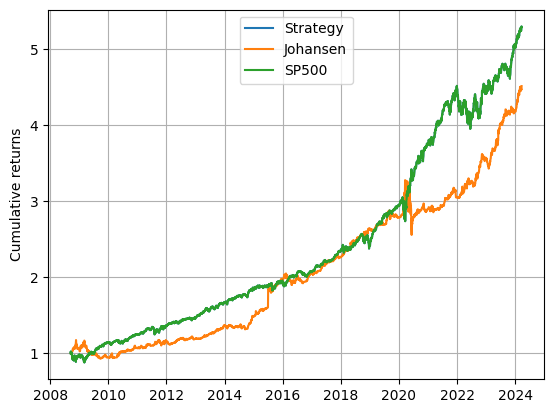

In [19]:
YEAR = 252
def calc_sharpe(rets):
    rates_df = pd.read_csv('Pairs_SP500_FPT/DTB6.csv')
    rates_df['DATE'] = pd.to_datetime(rates_df['DATE'])
    rates_df['DTB6'] = pd.to_numeric(rates_df['DTB6'], errors='coerce')
    rates_df['DTB6'] = rates_df['DTB6'].interpolate()
    rates_df = rates_df[rates_df['DATE'].isin(rets.index)]
    rates_df.set_index('DATE', inplace=True)
    comb = rets.merge(rates_df, how='inner',left_index=True, right_index=True)
    comb['exc'] = comb['rets'] - comb['DTB6']/100/YEAR
    return comb['exc'].mean()*252 / comb['rets'].std() / np.sqrt(YEAR)

fig, ax1 = plt.subplots()
ax1.plot(rets.index, (1+rets['rets']).cumprod())
ax1.plot(rets2.index, (1+rets2['rets']).cumprod())
# ax1.plot(rets_long.index, (1+rets_long['rets']).cumprod())
# ax1.plot(rets_short.index, (1+rets_short['rets']).cumprod())
ax1.plot(benchmark.index, (1+benchmark['rets']).cumprod())
# ax1.legend(['Strategy','Strategy Long', 'Strategy Short','SP500'], loc='upper center')
ax1.legend(['Strategy','Johansen','SP500'], loc='upper center')
ax1.set_ylabel('Cumulative returns')

# ax2 = ax1.twinx()
# ax2.plot(open_pos.index, open_pos['open_positions'], '-k', alpha=.6)
# ax2.legend(['Open pairs'], loc='lower right')
# ax2.set_ylabel('Open pairs')

plt.grid()

sp_strat = calc_sharpe(rets)
sp_strat = calc_sharpe(rets2)
# sp_strat_pos = calc_sharpe(rets_long)
# sp_strat_neg = calc_sharpe(rets_short)
sp_benchmark = calc_sharpe(benchmark)
print(f'Sharpe ratio Strategy: {sp_strat:.4f}')
print(f'Sharpe ratio Strategy Long: {sp_strat_pos:.4f}')
print(f'Sharpe ratio Strategy Short: {sp_strat_neg:.4f}')
print(f'Sharpe ratio SP500: {sp_benchmark:.4f}')

In [4]:
def read_factors(model='ff3'):
    
    if model == 'ff3':
        factors = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', index_col=0, parse_dates=True)
        factors = factors.drop('RF', axis=1)
        factors.columns = [c.lower().strip() for c in factors.columns]
        factors_list = list(factors.columns)
        for f in factors_list:
            factors[f] = pd.to_numeric(factors[f], errors='coerce')/100
        factors = factors.dropna()
    elif model == 'ff5':
        factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', index_col=0, parse_dates=True)
        factors = factors.drop('RF', axis=1)
        factors.columns = [c.lower().strip() for c in factors.columns]
        factors_list = list(factors.columns)
        for f in factors_list:
            factors[f] = pd.to_numeric(factors[f], errors='coerce')/100
        factors = factors.dropna()
    elif model == 'ffc4':
        factors_1, _ = read_factors(model='ff3')
        factors_2 = pd.read_csv('F-F_Momentum_Factor_daily.CSV', index_col=0, parse_dates=True)
        factors_2.columns = [c.lower().strip() for c in factors_2.columns]
        for f in factors_2.columns:
            factors_2[f] = pd.to_numeric(factors_2[f], errors='coerce')/100
        factors = factors_1.merge(factors_2, left_index=True, right_index=True, how='inner')
        factors_list = list(factors.columns)
        factors = factors.dropna()
    else:
        raise ValueError("The model must be one of 'ff3', 'ff5' or 'ffc4'")

    return factors, factors_list
factors, factors_list = read_factors(model='ffc4')
factors.head()

,mkt-rf,smb,hml,mom
1926-11-03,0.0020,-0.0020,-0.0033,0.0056
1926-11-04,0.0059,-0.0012,0.0065,-0.0050
1926-11-05,0.0007,-0.0011,0.0026,0.0117
1926-11-06,0.0016,-0.0029,0.0005,-0.0003
1926-11-08,0.0052,-0.0012,0.0018,-0.0001


In [5]:
risk_free = pd.read_csv('Pairs_SP500_FPT/DTB6.csv', index_col=0, parse_dates=True)
risk_free = risk_free.rename(columns={
    'DTB6': 'rf'
})
risk_free['rf'] = pd.to_numeric(risk_free['rf'], errors='coerce')
risk_free = risk_free.dropna()
risk_free['rf'] = risk_free['rf']/100/365
risk_free.head()

,rf
DATE,
1997-01-02,0.000141
1997-01-03,0.000141
1997-01-06,0.000140
1997-01-07,0.000140
1997-01-08,0.000140


In [6]:
vol_spread = pd.read_csv('Pairs_SP500_FPT/spx_impl_minus_hist_vol.csv', index_col=0, parse_dates=True)
vol_spread['vol_spread'] /= 100
# vol_spread = (vol_spread - vol_spread.mean())/vol_spread.std()
vol_spread.head()

,vol_spread
Date,
1990-01-02,0.035983
1990-01-03,0.044316
1990-01-04,0.050416
1990-01-05,0.051965
1990-01-08,0.083356


In [7]:
vol_premium = pd.read_csv('Pairs_SP500_FPT/1mo_rolling_impl_minus_hist_vol.csv', index_col=0, parse_dates=True)
vol_premium /= 100
melted_vol_premium = vol_premium.reset_index().melt(id_vars='Date', var_name='stock', value_name='vol_premium')
melted_vol_premium

,Date,stock,vol_premium
0,2003-01-23,AAPL_US,0.115398
1,2003-01-24,AAPL_US,0.100478
2,2003-01-27,AAPL_US,0.070721
3,2003-01-28,AAPL_US,0.031679
4,2003-01-29,AAPL_US,0.027780
...,...,...,...
2040143,2023-05-26,ZION_US,0.072069
2040144,2023-05-30,ZION_US,0.034767
2040145,2023-05-31,ZION_US,0.008920
2040146,2023-06-01,ZION_US,0.012933


In [8]:
market_spread_over_sp = pd.read_csv('Pairs_SP500_FPT/1mo_rolling_hist_stock_minus_sp_vol.csv', index_col=0, parse_dates=True)
market_spread_over_sp /= 100
melted_market_spread_over_sp = market_spread_over_sp.reset_index().melt(id_vars='Date', var_name='stock', value_name='spread_over_sp')
melted_market_spread_over_sp

,Date,stock,spread_over_sp
0,2003-01-23,AAPL_US,0.028605
1,2003-01-24,AAPL_US,0.011742
2,2003-01-27,AAPL_US,0.070398
3,2003-01-28,AAPL_US,0.093095
4,2003-01-29,AAPL_US,0.095857
...,...,...,...
2040143,2023-05-26,ZION_US,0.570245
2040144,2023-05-30,ZION_US,0.593392
2040145,2023-05-31,ZION_US,0.630813
2040146,2023-06-01,ZION_US,0.580512


In [9]:
factors['mkt-rf'] = factors['mkt-rf'].astype(np.float32)
factors['smb'] = factors['smb'].astype(np.float32)
factors['hml'] = factors['hml'].astype(np.float32)
factors['mom'] = factors['mom'].astype(np.float32)
rets['rets'] = rets['rets'].astype(np.float32)
risk_free['rf'] = risk_free['rf'].astype(np.float32)
vol_spread['vol_spread'] = vol_spread['vol_spread'].astype(np.float32)
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = rets.merge(factors, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(risk_free, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(melted_market_spread_over_sp, left_index=True, right_on='Date', how='left')
full_dataset = full_dataset.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
# full_dataset = benchmark.merge(factors, left_index=True, right_index=True, how='inner').merge(risk_free, left_index=True, right_index=True, how='inner').merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset['exc_rets'] = full_dataset['rets'] - full_dataset['rf']
# full_dataset = full_dataset.dropna()
full_dataset.index = full_dataset['Date']
full_dataset = full_dataset.drop(['Date'], axis=1)
full_dataset = full_dataset.dropna()

# Factor regression

## Full Regression - Strategy

In [10]:
full_dataset = full_dataset.reset_index()
full_dataset = full_dataset.set_index(['stock', 'Date'])

In [11]:
Y = full_dataset['exc_rets']
factors_list = list(set(full_dataset.columns) - set(['rets','exc_rets','rf']))
X = full_dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,exc_rets,R-squared:,0.0263
Estimator:,PanelOLS,R-squared (Between):,-7.424e+28
No. Observations:,1674546,R-squared (Within):,0.0263
Date:,"Tue, Apr 02 2024",R-squared (Overall):,0.0263
Time:,17:43:43,Log-likelihood,6.314e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6470.4
Entities:,397,P-value,0.0000
Avg Obs:,4218.0,Distribution:,"F(7,1674142)"
Min Obs:,4218.0,,
Max Obs:,4218.0,F-statistic (robust):,6470.4


## Full Regression - Strategy Long

In [12]:
factors['mkt-rf'] = factors['mkt-rf'].astype(np.float32)
factors['smb'] = factors['smb'].astype(np.float32)
factors['hml'] = factors['hml'].astype(np.float32)
factors['mom'] = factors['mom'].astype(np.float32)
rets['rets'] = rets['rets'].astype(np.float32)
risk_free['rf'] = risk_free['rf'].astype(np.float32)
vol_spread['vol_spread'] = vol_spread['vol_spread'].astype(np.float32)
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = rets_long.merge(factors, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(risk_free, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(melted_market_spread_over_sp, left_index=True, right_on='Date', how='left')
full_dataset = full_dataset.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
full_dataset['exc_rets'] = full_dataset['rets'] - full_dataset['rf']
full_dataset.index = full_dataset['Date']
full_dataset = full_dataset.drop(['Date'], axis=1)
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.reset_index()
full_dataset = full_dataset.set_index(['stock', 'Date'])

Y = full_dataset['exc_rets']
factors_list = list(set(full_dataset.columns) - set(['rets','exc_rets','rf']))
X = full_dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,exc_rets,R-squared:,0.0220
Estimator:,PanelOLS,R-squared (Between):,-4.512e+29
No. Observations:,1674546,R-squared (Within):,0.0220
Date:,"Tue, Apr 02 2024",R-squared (Overall):,0.0220
Time:,17:44:34,Log-likelihood,5.871e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5390.1
Entities:,397,P-value,0.0000
Avg Obs:,4218.0,Distribution:,"F(7,1674142)"
Min Obs:,4218.0,,
Max Obs:,4218.0,F-statistic (robust):,5390.1


## Full Regression - Strategy Short

In [13]:
factors['mkt-rf'] = factors['mkt-rf'].astype(np.float32)
factors['smb'] = factors['smb'].astype(np.float32)
factors['hml'] = factors['hml'].astype(np.float32)
factors['mom'] = factors['mom'].astype(np.float32)
rets['rets'] = rets['rets'].astype(np.float32)
risk_free['rf'] = risk_free['rf'].astype(np.float32)
vol_spread['vol_spread'] = vol_spread['vol_spread'].astype(np.float32)
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = rets_short.merge(factors, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(risk_free, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(melted_market_spread_over_sp, left_index=True, right_on='Date', how='left')
full_dataset = full_dataset.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
full_dataset['exc_rets'] = full_dataset['rets'] - full_dataset['rf']
full_dataset.index = full_dataset['Date']
full_dataset = full_dataset.drop(['Date'], axis=1)
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.reset_index()
full_dataset = full_dataset.set_index(['stock', 'Date'])

Y = full_dataset['exc_rets']
factors_list = list(set(full_dataset.columns) - set(['rets','exc_rets','rf']))
X = full_dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,exc_rets,R-squared:,0.0264
Estimator:,PanelOLS,R-squared (Between):,-1.281e+29
No. Observations:,1674546,R-squared (Within):,0.0264
Date:,"Tue, Apr 02 2024",R-squared (Overall):,0.0263
Time:,17:46:55,Log-likelihood,6.993e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,6473.3
Entities:,397,P-value,0.0000
Avg Obs:,4218.0,Distribution:,"F(7,1674142)"
Min Obs:,4218.0,,
Max Obs:,4218.0,F-statistic (robust):,6473.3


## Volatility Premium as Spread over SP regression

In [14]:
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = melted_market_spread_over_sp.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
full_dataset = full_dataset.dropna()
full_dataset = full_dataset.set_index(['stock', 'Date'])

Y = full_dataset['vol_premium']
factors_list = list(set(full_dataset.columns) - set(['vol_premium']))
X = full_dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,vol_premium,R-squared:,0.0954
Estimator:,PanelOLS,R-squared (Between):,-0.3695
No. Observations:,2035022,R-squared (Within):,0.0954
Date:,"Tue, Apr 02 2024",R-squared (Overall):,0.0706
Time:,17:47:34,Log-likelihood,-4.051e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.145e+05
Entities:,397,P-value,0.0000
Avg Obs:,5126.0,Distribution:,"F(1,2034624)"
Min Obs:,5126.0,,
Max Obs:,5126.0,F-statistic (robust):,2.145e+05
